# Soil temperature prediction (outer weather + radiation)

Goal: predict `soil_temp_C` using only Bet Dagan outer weather and radiation data.

Inputs:
- `bet_dagan_weather.csv` (outer air temp, humidity, wind, etc.)
- `bet_dagan_radiation.csv` (global/diffuse/direct radiation)
- `Data Final OG.csv` (provides the target `soil_temp_C` with timestamps)

In [ ]:
# Repo paths (works even when notebook is in scripts/)
from pathlib import Path

def find_repo_root(start=None):
    start = Path.cwd() if start is None else Path(start)
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    return start

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
PLOTS.mkdir(exist_ok=True)


In [113]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")


## Load and clean sources

In [114]:
soil_path = str(RAW / 'Data Final OG.csv')
weather_path = str(RAW / 'bet_dagan_weather.csv')
radiation_path = str(RAW / 'bet_dagan_radiation.csv')

# Soil data (target)
soil = pd.read_csv(soil_path)
soil['datetime'] = pd.to_datetime(soil['datetime'] + ' ' + soil['time'], dayfirst=False, errors='coerce')
soil = soil[['datetime', 'soil_temp_C']].dropna(subset=['datetime', 'soil_temp_C'])
soil = soil.sort_values('datetime').reset_index(drop=True)

# Weather data (outer conditions)
weather = pd.read_csv(weather_path, encoding='utf-8')
weather.columns = weather.columns.str.strip().str.replace('"', '', regex=False)
w_cols = weather.columns.tolist()
weather = weather.rename(columns={
    w_cols[1] if len(w_cols) > 1 else 'datetime': 'datetime',
    w_cols[4] if len(w_cols) > 4 else 'outer_temp_C': 'outer_temp_C',
    w_cols[3] if len(w_cols) > 3 else 'outer_rh_pct': 'outer_rh_pct',
    w_cols[11] if len(w_cols) > 11 else 'outer_wind_ms': 'outer_wind_ms',
})
weather['datetime'] = pd.to_datetime(weather['datetime'], dayfirst=True, errors='coerce')
weather = weather[['datetime', 'outer_temp_C', 'outer_rh_pct', 'outer_wind_ms']]

# Radiation data
radiation = pd.read_csv(radiation_path, encoding='utf-8')
radiation.columns = radiation.columns.str.strip().str.replace('"', '', regex=False)
r_cols = radiation.columns.tolist()
radiation = radiation.rename(columns={
    r_cols[1] if len(r_cols) > 1 else 'datetime': 'datetime',
    r_cols[3] if len(r_cols) > 3 else 'global_rad_Wm2': 'global_rad_Wm2',
    r_cols[2] if len(r_cols) > 2 else 'diffuse_rad_Wm2': 'diffuse_rad_Wm2',
    r_cols[4] if len(r_cols) > 4 else 'direct_rad_Wm2': 'direct_rad_Wm2',
})
radiation['datetime'] = pd.to_datetime(radiation['datetime'], dayfirst=True, errors='coerce')
radiation = radiation[['datetime', 'global_rad_Wm2', 'diffuse_rad_Wm2', 'direct_rad_Wm2']]

# Merge all on timestamp (inner join keeps rows where all sources overlap)
merged = soil.merge(weather, on='datetime', how='inner')
merged = merged.merge(radiation, on='datetime', how='inner')
merged = merged.sort_values('datetime').reset_index(drop=True)
print('Merged shape:', merged.shape)
merged.head()


Merged shape: (4306, 8)


,datetime,soil_temp_C,outer_temp_C,outer_rh_pct,outer_wind_ms,global_rad_Wm2,diffuse_rad_Wm2,direct_rad_Wm2
0,2025-08-10 12:30:00,37.70,34.8,53,3.5,919,262,646
1,2025-08-10 12:40:00,37.82,34.8,52,3.9,924,261,651
2,2025-08-10 12:50:00,37.41,34.8,52,3.7,925,262,649
3,2025-08-10 13:00:00,37.07,35.1,51,4.2,925,263,648
4,2025-08-10 13:10:00,39.13,35.2,51,4.0,919,264,643


## Feature prep
- Keep only Bet Dagan predictors: outer temp, humidity, wind, and radiation (global/diffuse/direct).
- Add cyclic time features to capture diurnal/seasonal effects.
- Clean numeric columns and fill small gaps by interpolation/forward fill.

In [115]:
target_col = "soil_temp_C"
feature_cols = [
    "outer_temp_C",
    "outer_rh_pct",
    "outer_wind_ms",
    "global_rad_Wm2",
    "diffuse_rad_Wm2",
    "direct_rad_Wm2",
]

# Training set (with soil_temp_C)
for col in feature_cols:
    merged[col] = pd.to_numeric(merged[col], errors="coerce")

merged["hour"] = merged["datetime"].dt.hour
merged["dayofyear"] = merged["datetime"].dt.dayofyear
merged["sin_hour"] = np.sin(2 * np.pi * merged["hour"] / 24)
merged["cos_hour"] = np.cos(2 * np.pi * merged["hour"] / 24)
merged["sin_doy"] = np.sin(2 * np.pi * merged["dayofyear"] / 365)
merged["cos_doy"] = np.cos(2 * np.pi * merged["dayofyear"] / 365)

feature_cols_time = feature_cols + ["sin_hour", "cos_hour", "sin_doy", "cos_doy"]

# Drop rows without target and fill small feature gaps
dataset = merged.dropna(subset=[target_col]).copy()
dataset[feature_cols_time] = dataset[feature_cols_time].interpolate(limit_direction="both").bfill().ffill()

# Prediction frame over full weather date range
predict_base = weather.merge(radiation, on="datetime", how="left").sort_values("datetime")
for col in feature_cols:
    predict_base[col] = pd.to_numeric(predict_base[col], errors="coerce")

predict_base["hour"] = predict_base["datetime"].dt.hour
predict_base["dayofyear"] = predict_base["datetime"].dt.dayofyear
predict_base["sin_hour"] = np.sin(2 * np.pi * predict_base["hour"] / 24)
predict_base["cos_hour"] = np.cos(2 * np.pi * predict_base["hour"] / 24)
predict_base["sin_doy"] = np.sin(2 * np.pi * predict_base["dayofyear"] / 365)
predict_base["cos_doy"] = np.cos(2 * np.pi * predict_base["dayofyear"] / 365)

predict_features = predict_base[["datetime"] + feature_cols_time].copy()
predict_features[feature_cols_time] = predict_features[feature_cols_time].interpolate(limit_direction="both").bfill().ffill()

dataset[feature_cols_time + [target_col]].describe().T


,count,mean,std,min,25%,50%,75%,max
outer_temp_C,4306.0,28.471505,3.501225,20.000000,25.900000,2.840000e+01,31.300000,37.000000
outer_rh_pct,4306.0,66.312123,12.660514,32.000000,55.000000,6.600000e+01,77.000000,93.000000
outer_wind_ms,4306.0,2.490966,1.379872,0.100000,1.300000,2.200000e+00,3.600000,6.700000
global_rad_Wm2,4306.0,285.982815,351.143077,0.000000,0.000000,3.150000e+01,617.750000,1031.000000
diffuse_rad_Wm2,4306.0,74.973758,90.789271,0.000000,0.000000,2.850000e+01,133.000000,421.000000
direct_rad_Wm2,4306.0,269.500000,314.449074,0.000000,0.000000,1.500000e+00,607.000000,836.000000
sin_hour,4306.0,-0.001738,0.703511,-1.000000,-0.707107,0.000000e+00,0.707107,1.000000
cos_hour,4306.0,-0.008825,0.710791,-1.000000,-0.707107,-1.836970e-16,0.707107,1.000000
sin_doy,4306.0,-0.841166,0.110294,-0.979614,-0.948362,-8.497856e-01,-0.741222,-0.628763
cos_doy,4306.0,-0.497326,0.181528,-0.777597,-0.671260,-5.270582e-01,-0.317191,-0.200891


In [116]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}\nR^2: {r2:.3f}")


MAE: 0.393
R^2: 0.935


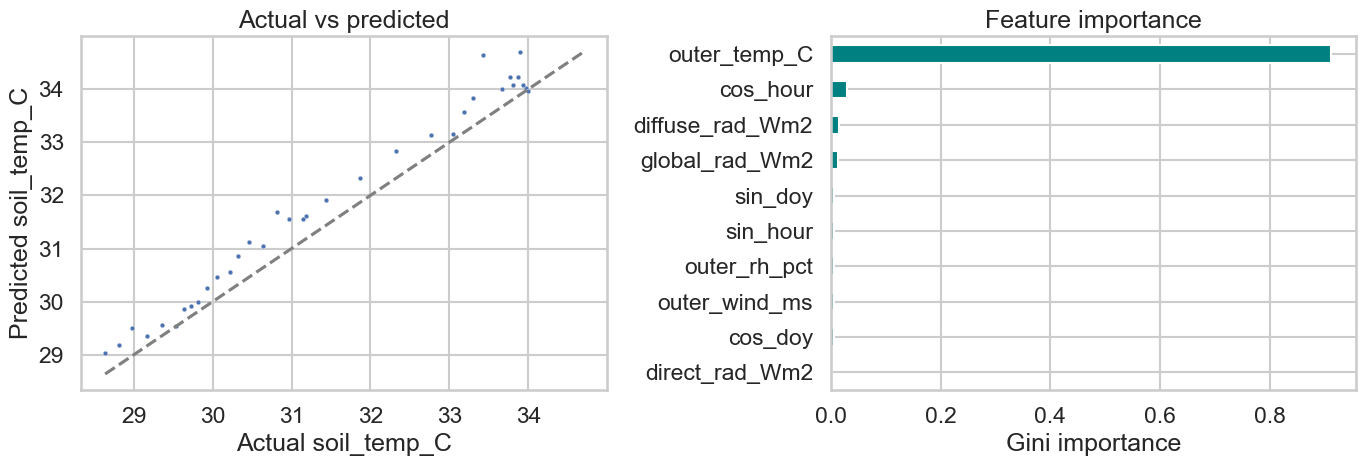

In [117]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=y_test, y=y_pred, ax=axes[0], s=12)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
axes[0].plot(lims, lims, linestyle="--", color="gray")
axes[0].set_xlabel("Actual soil_temp_C")
axes[0].set_ylabel("Predicted soil_temp_C")
axes[0].set_title("Actual vs predicted")

importances = pd.Series(rf.feature_importances_, index=feature_cols_time).sort_values()
importances.plot.barh(ax=axes[1], color="teal")
axes[1].set_title("Feature importance")
axes[1].set_xlabel("Gini importance")

plt.tight_layout()
plt.show()


## Walk-forward (10 days train ? 1 day test)
Rolling evaluation that retrains on an expanding window: start with 10 days of data, predict the next day, then grow the training window by one day each step.

Average walk-forward metrics:
mae    0.782767
r2     0.921795
dtype: float64
All walk-forward windows:
 step           train_end          test_start            test_end      mae       r2  train_rows  test_rows
    3 2025-08-23 12:30:00 2025-08-23 12:30:00 2025-08-24 12:30:00 0.804532 0.945998        1220        144
    4 2025-08-24 12:30:00 2025-08-24 12:30:00 2025-08-25 12:30:00 0.727896 0.932915        1364        144
    5 2025-08-25 12:30:00 2025-08-25 12:30:00 2025-08-26 12:30:00 1.213370 0.802605        1508        144
    6 2025-08-26 12:30:00 2025-08-26 12:30:00 2025-08-27 12:30:00 0.782311 0.908440        1652        144
    7 2025-08-27 12:30:00 2025-08-27 12:30:00 2025-08-28 12:30:00 0.619121 0.918648        1796        144
    8 2025-08-28 12:30:00 2025-08-28 12:30:00 2025-08-29 12:30:00 1.078326 0.910105        1940        144
    9 2025-08-29 12:30:00 2025-08-29 12:30:00 2025-08-30 12:30:00 0.664605 0.969572        2084        144
   15 2025-09-04 12:30:00 2025-09-04 12:3

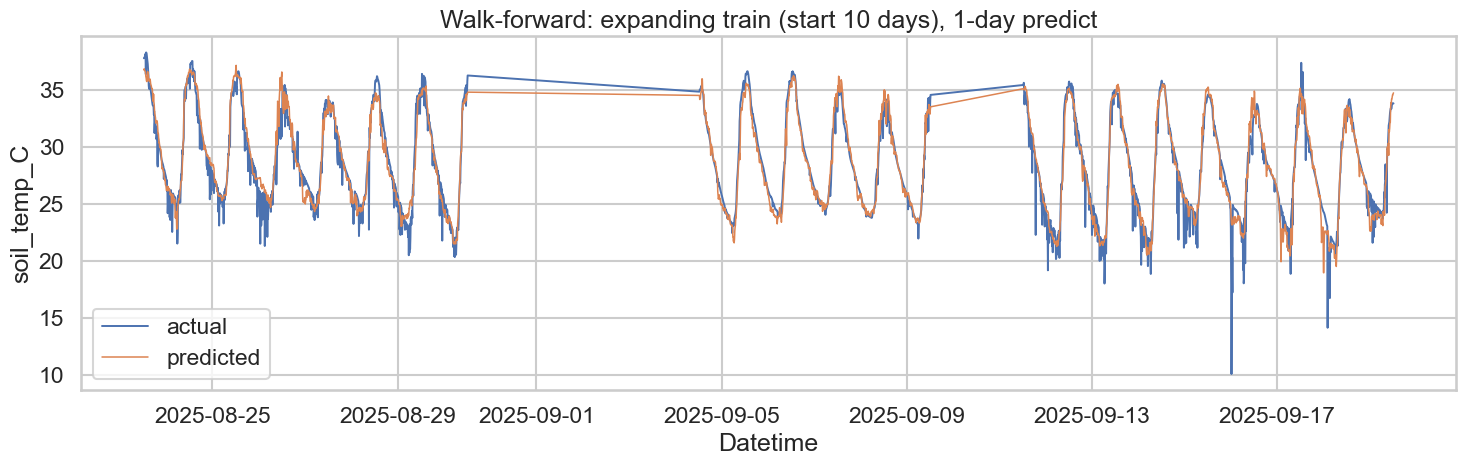

In [118]:
from datetime import timedelta

# Expanding-window walk-forward: start with 10 days train, predict next day, then grow the train window by 1 day each step.
train_window = timedelta(days=10)
test_window = timedelta(days=1)
min_train_rows = 200
expected_test_rows = 144  # exactly one day of 10-min samples

# Ensure chronological order
df_wf = dataset.sort_values('datetime').reset_index(drop=True)
origin_time = df_wf['datetime'].min()
end_time = df_wf['datetime'].max()

wf_metrics = []
wf_preds = []
step = 0

while True:
    train_end = origin_time + train_window + step * test_window
    test_start = train_end
    test_end = test_start + test_window

    if test_start >= end_time:
        break

    train_mask = df_wf['datetime'] < train_end
    test_mask = (df_wf['datetime'] >= test_start) & (df_wf['datetime'] < test_end)

    X_train = df_wf.loc[train_mask, feature_cols_time]
    y_train = df_wf.loc[train_mask, target_col]
    X_test = df_wf.loc[test_mask, feature_cols_time]
    y_test = df_wf.loc[test_mask, target_col]

    if len(X_train) < min_train_rows or len(X_test) != expected_test_rows:
        step += 1
        continue

    model = RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    wf_metrics.append({
        'step': step,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': test_end,
        'mae': mae,
        'r2': r2,
        'train_rows': len(X_train),
        'test_rows': len(X_test),
    })

    wf_preds.append(pd.DataFrame({
        'datetime': df_wf.loc[test_mask, 'datetime'],
        'actual': y_test.values,
        'predicted': y_pred,
    }))

    step += 1

wf_pred_df = pd.concat(wf_preds, ignore_index=True) if wf_preds else pd.DataFrame(columns=['datetime','actual','predicted'])
wf_metrics_df = pd.DataFrame(wf_metrics)

if not wf_metrics_df.empty:
    print('Average walk-forward metrics:')
    print(wf_metrics_df[['mae','r2']].mean())
    print('All walk-forward windows:')
    print(wf_metrics_df.to_string(index=False))

    plt.figure(figsize=(15,5))
    plt.plot(wf_pred_df['datetime'], wf_pred_df['actual'], label='actual', linewidth=1.4)
    plt.plot(wf_pred_df['datetime'], wf_pred_df['predicted'], label='predicted', linewidth=1.1)
    plt.xlabel('Datetime')
    plt.ylabel('soil_temp_C')
    plt.title('Walk-forward: expanding train (start 10 days), 1-day predict')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('Walk-forward produced no predictions (check datetime coverage).')


## Notes / next ideas
- If timestamps do not align exactly, consider rounding both sources to the same 10-minute bins before merging.
- You can enrich features with lagged versions of `soil_temp_C` or humidity if allowed, but this notebook keeps only Bet Dagan weather/radiation as requested.
- Try gradient boosting (XGBoost/LightGBM/CatBoost) for potentially higher accuracy.

## Final model and full-range predictions
Train on all labeled data, then predict soil temperature for the entire weather date range (weather + radiation).

In [119]:
# Train final model on full labeled dataset
final_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)
final_model.fit(dataset[feature_cols_time], dataset[target_col])

pred_all = final_model.predict(predict_features[feature_cols_time])
pred_df = pd.DataFrame({
    'datetime': predict_features['datetime'],
    'soil_temp_pred': pred_all,
})

outfile = str(PROCESSED / 'soil_temp_predictions_full_range.csv')
pred_df.to_csv(outfile, index=False)

print('Prediction coverage:', len(pred_df), 'rows')
print('Saved predictions to', outfile)
print(pred_df.head())
print(pred_df.tail())


Prediction coverage: 16690 rows
Saved predictions to soil_temp_predictions_full_range.csv
             datetime  soil_temp_pred
0 2025-05-29 00:00:00       20.267679
1 2025-05-29 00:10:00       20.267679
2 2025-05-29 00:20:00       20.267679
3 2025-05-29 00:30:00       20.177434
4 2025-05-29 00:40:00       19.947642
                 datetime  soil_temp_pred
16685 2025-09-21 22:20:00       27.712522
16686 2025-09-21 22:30:00       27.712522
16687 2025-09-21 22:40:00       27.712522
16688 2025-09-21 22:50:00       27.251613
16689 2025-09-21 23:00:00       27.072083
